# Introduction

.....

## Imports

In [11]:
import tensorflow as tf
import numpy as np
import cv2
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization

import random
import matplotlib.pyplot as plt

## Load Data

In [3]:
lines = []

with open('.\windows_sim\Training Data\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurments = []

#This loads the data from the following path 
# ".\windows_sim\Training Data\IMG"
#This path needs to be located in the same folder as this notebook. 

#Load Dataset 1
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path ='.\windows_sim\Training Data\IMG' 
        current_path = current_path + filename[121-35:] #The split did not work well..
        image = cv2.imread(current_path)


        #The cv2 function makes the rgb coding right for matplotlib, this does not matter for the DL-model

        measurment = float(line[3])
        add = 0
        if i == 1:
            add += 0.2
        elif i == 2:
            add -= 0.2
            
        chanse_keep_0 = random.randint(1,10)
        if chanse_keep_0 <=1 and measurment == 0:
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            measurment += add
            measurments.append(measurment)
        elif measurment != 0:
            measurment += add
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            measurments.append(measurment)

print("Dataset 1 done")
#Load Dataset 2
lines2 = []
with open('.\windows_sim\Training Data\IMG\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines2.append(line)
        
for line in lines2:
    for i in range(3):
        source_path = line[0]
        filename = source_path.split('/')[-1]
        current_path ='.\windows_sim\Training Data\IMG\IMG' 
        current_path = current_path + filename[len(filename)-len(current_path):] #The split did not work well..
        image = cv2.imread(current_path)


        #The cv2 function makes the rgb coding right for matplotlib, this does not matter for the DL-model

        measurment = float(line[3])
        add = 0
        if i == 1:
            add += 0.2
        elif i == 2:
            add -= 0.2
            
        chanse_keep_0 = random.randint(1,10)
        if chanse_keep_0 <=1 and measurment == 0:
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            measurment += add
            measurments.append(measurment)
        elif measurment != 0:
            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            measurment += add
            measurments.append(measurment)


print("Dataset 2 done")      
X_raw = np.array(images)
y_raw = np.array(measurments)
y_raw = y_raw.reshape(len(y_raw),1)

print(y_raw.shape)

#Split into test, train and validation data
#REMOVE THIS!! 

X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.2, random_state=0)


Dataset 1 done
(11555, 1)


### Understad the data

Number of Training exampels : 9244
Number of Validation exampels : 2311

Image Data Shape : (9244, 160, 320, 3)
Label typ : <class 'numpy.ndarray'>
Feature typ : <class 'numpy.ndarray'>


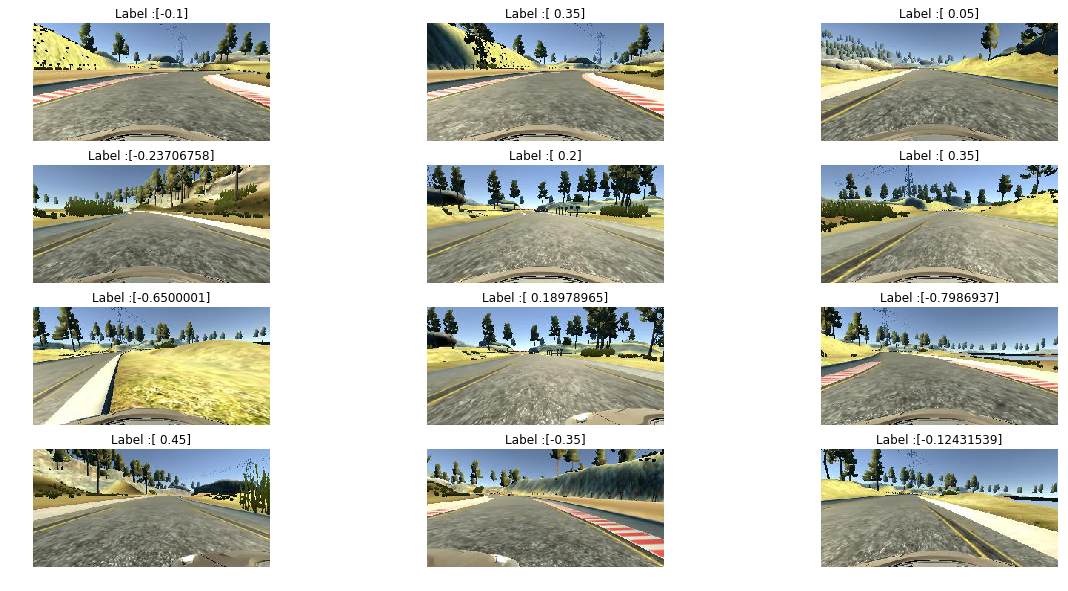

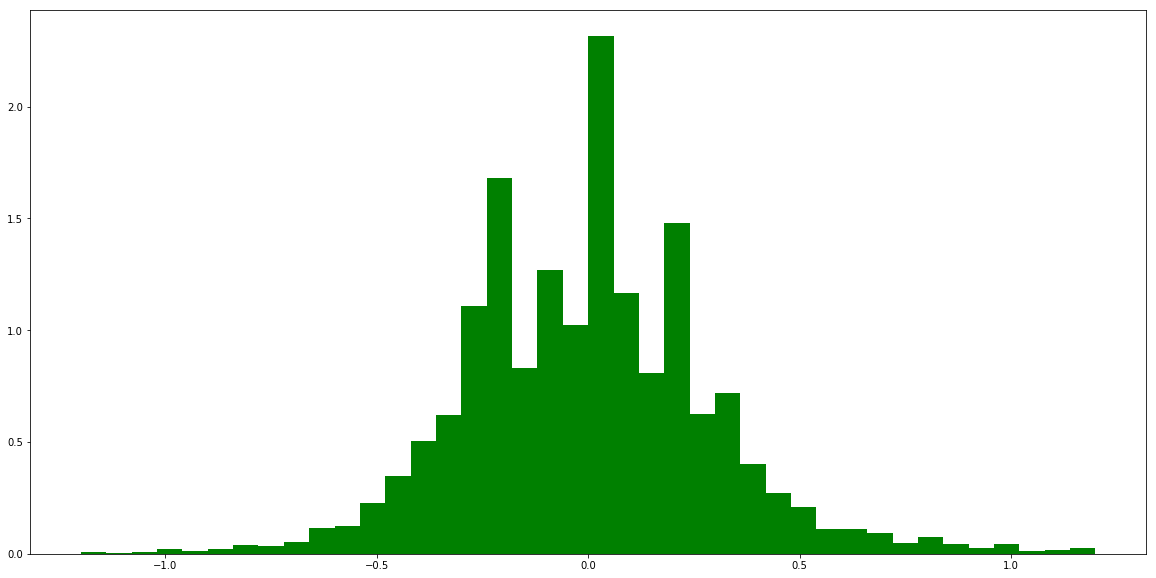

In [4]:
print('Number of Training exampels :', len(X_train))
print('Number of Validation exampels :', len(X_val))


print("")
print('Image Data Shape :', X_train.shape)
print("Label typ :", type(y_train[0]))
print("Feature typ :", type(X_train[0]))

#Show some datapoints (Images with labels)
grid_x, grid_y = 4, 3
f1, cell1 = plt.subplots(grid_x, grid_y, figsize=(20,10))


for i in range(grid_x):
    for j in range(grid_y):
        index = np.random.randint(len(X_train))
        cell1[i,j].imshow(X_train[index])
        cell1[i,j].set_title('Label :{}' .format(y_train[index]))
        cell1[i,j].axis('off')

        
#Shows a histogram over the data, giving understanding of the distrubution
fig2 = plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(y_train,40,  normed=1, facecolor='green')



plt.show()

        


### Analysis 

It seems as there are a lot more exampels of driving straight forward than turning. This migt be a problem during training, as it will lead to the model gaining very high accuracy by only driving forward. So there is a point to augmenting the data to gain a more "normal" distrubution of the dataset. 

### Data augmentation

#### Useful function

In [12]:
def augment_img(img):
    '''
    A function to increse the number of images in the dataset. 
    This function performes data augmentation on the images, giving images of different brightness... (more?)
    '''
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
   

    h, s, v = cv2.split(new_img)
    v += 25
    final_hsv = cv2.merge((h, s, v))

    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 
    
    

#### Flipping images

In [19]:
X_train_fliped = [] 
y_train_fliped = []

#Flipping images that is turning
for i in range(len(X_train)):
    if(y_train[i] != 0.0 ):
        
        X_train_fliped.append(np.fliplr(X_train[i]))
        y_train_fliped.append(-y_train[i])
        
    X_train_fliped.append((X_train[i]))
    y_train_fliped.append(y_train[i])
    
    
X_train = np.array(X_train_fliped)
y_train = np.array(y_train_fliped)


MemoryError: 

#### Visualization 

(9244, 160, 320, 3)


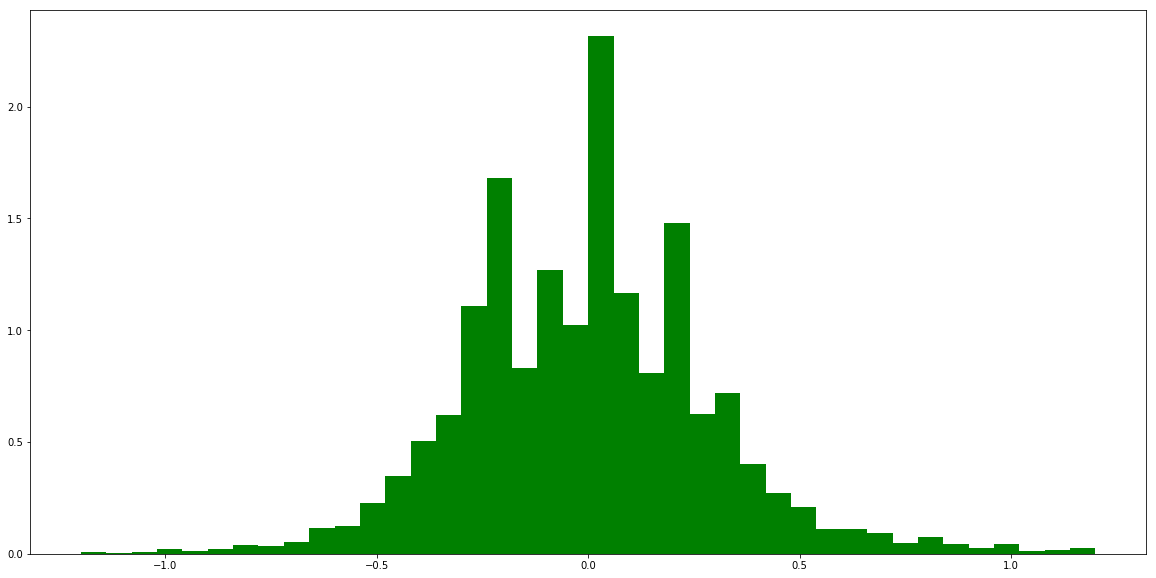

In [20]:
#Shows a histogram over the data, giving understanding of the distrubution
fig2 = plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(y_train,40,  normed=1, facecolor='green')
print(X_train.shape)
plt.show()

## The Network

In [22]:
#Test model


model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = (160,320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(10))
model.add(Dense(1))


In [49]:

model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = (160,320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))


model.add(Conv2D(24, 5, 5, subsample = (2,2), activation='relu'))
model.add(Dropout(0.25))


model.add(Conv2D(36, 5, 5,  subsample = (2,2),activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(48, 5, 5, subsample = (2,2), activation='relu'))

model.add(Conv2D(64, 3, 3, activation='relu'))

model.add(Conv2D(64, 3, 3, activation='relu'))


model.add(Flatten())
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


## Training

In [24]:
#Hyperparameters: 
rate = 0.001
EPOCHS = 7
BATCH_SIZE = 8
dropout = 0.5

#model.load_weights("model.h5")
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, shuffle = True, nb_epoch = EPOCHS , validation_data = (X_val, y_val))

model.save('model_2.h5')


Train on 9244 samples, validate on 2311 samples
Epoch 1/7
9244/9244 [==============================] - 121s - loss: 19.7441 - val_loss: 0.3512
Epoch 2/7
9244/9244 [==============================] - 94s - loss: 0.2784 - val_loss: 0.1492
Epoch 3/7
7072/9244 [=====================>........] - ETA: 23s - loss: 0.3899

KeyboardInterrupt: 

#### Training history 

dict_keys(['val_loss', 'loss'])


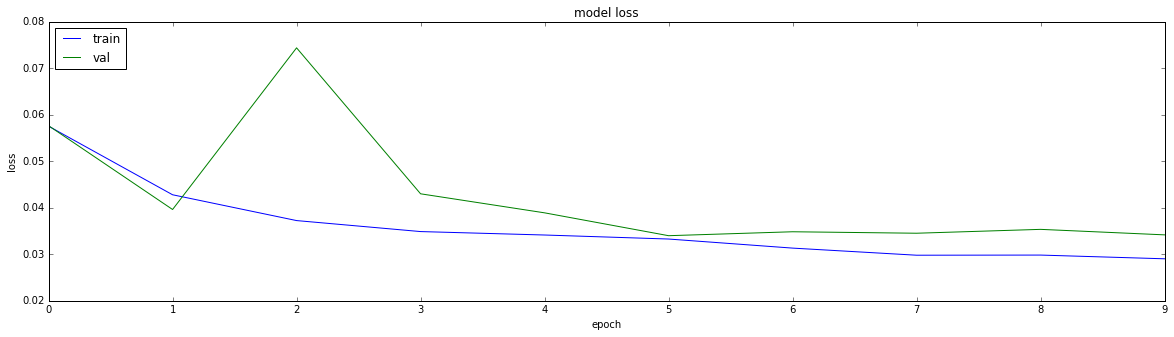

In [41]:

print(history.history.keys())  

plt.figure(figsize=(20,5))  


# summarize history for loss  

plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  
